In [1]:
import pandas as pd
import numpy as np

In [36]:
df = pd.read_csv("data/bank-full.csv", delimiter=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [37]:
req_cols = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 
            'pdays', 'previous', 'poutcome', 'y']

df = df[req_cols]

In [38]:
from pandas.api.types import is_numeric_dtype

numerical_cols = [col for col in df.columns.tolist() if is_numeric_dtype(df[col])]
cat_cols = list(set(df.columns) - set(numerical_cols))

numerical_cols

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

### QUESTION 1

In [85]:
for col in numerical_cols:
    if roc_auc_score(y, df[col]) < 0.5:
        print(col, roc_auc_score(y, -df[col]))
    else:
        print(col, roc_auc_score(y, df[col]))

age 0.5078552662471552
balance 0.590061489160812
day 0.5265199356555834
duration 0.8075955951124923
campaign 0.5723342144142696
pdays 0.593224032562116
previous 0.6023034054239005


In [39]:
# replace the values yes/no with 1/0
df['y'] = df.y.replace({"yes":1, "no":0})

y = df['y']

del df['y']

cat_cols.remove('y')

In [60]:
from sklearn.model_selection import train_test_split

X_full_train, X_test, y_full_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)

X_full_train = X_full_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_full_train = y_full_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=X_test.shape[0], random_state=1)

print(X_train.shape, X_val.shape, X_test.shape)

(27125, 14) (9043, 14) (9043, 14)


In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score
import warnings
warnings.filterwarnings("ignore")


In [62]:
dv = DictVectorizer(sparse=False)

train_dict = X_train.to_dict(orient="records")
X_train = dv.fit_transform(train_dict)

val_dict = X_val.to_dict(orient="records")
X_val = dv.transform(val_dict)

In [63]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(X_train, y_train)
pred_val = model.predict(X_val)

### QUESTION 2

In [64]:
auc = roc_auc_score(y_val, pred_val)
auc

0.6533433406582825

In [65]:
pred_val_prob = model.predict_proba(X_val)

In [66]:
precision_lst = []
recall_lst = []
f1_lst = []

for thresh in np.arange(0.0, 1.0, 0.01):
    pred_val = np.where(pred_val_prob[:,1]>thresh, 1, 0)
    precision_lst.append((thresh, precision_score(y_val, pred_val)))
    recall_lst.append((thresh, recall_score(y_val, pred_val)))
    f1_lst.append((thresh, f1_score(y_val, pred_val)))

### QUESTION 3

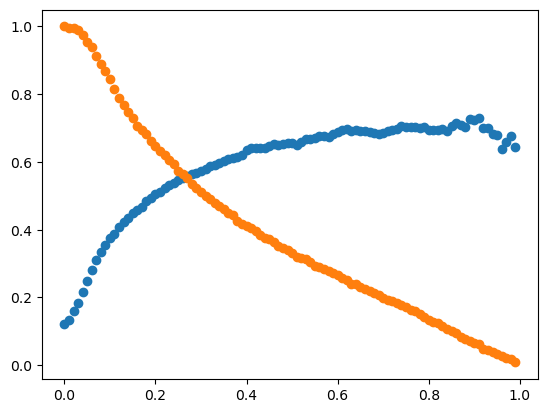

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter(*zip(*precision_lst))
plt.scatter(*zip(*recall_lst))

### QUESTION 4

In [68]:
f1_lst[np.argmax(np.array(f1_lst)[:, 1])]

(0.2, 0.5678913738019169)

### QUESTION 5

In [69]:
from sklearn.model_selection import KFold

In [75]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_lst = []

for train_idx, val_idx in kf.split(X_full_train):
    
    X_train = X_full_train.loc[train_idx]
    X_val = X_full_train.loc[val_idx]    
    
    y_train = y_full_train.loc[train_idx]
    y_val = y_full_train.loc[val_idx]    
    
    dv = DictVectorizer(sparse=False)

    train_dict = X_train.to_dict(orient="records")
    X_train = dv.fit_transform(train_dict)

    val_dict = X_val.to_dict(orient="records")
    X_val = dv.transform(val_dict)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    pred_val = model.predict(X_val)
    
    auc = roc_auc_score(y_val, pred_val)
    
    auc_lst.append(auc)

In [77]:
round(np.std(auc_lst), 3)

0.006

In [79]:
for C in [0.000001, 0.001, 1]:
    
    auc_lst = []

    for train_idx, val_idx in kf.split(X_full_train):

        X_train = X_full_train.loc[train_idx]
        X_val = X_full_train.loc[val_idx]    

        y_train = y_full_train.loc[train_idx]
        y_val = y_full_train.loc[val_idx]    

        dv = DictVectorizer(sparse=False)

        train_dict = X_train.to_dict(orient="records")
        X_train = dv.fit_transform(train_dict)

        val_dict = X_val.to_dict(orient="records")
        X_val = dv.transform(val_dict)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        pred_val = model.predict(X_val)

        auc = roc_auc_score(y_val, pred_val)

        auc_lst.append(auc)
        
    print(C, np.mean(auc_lst))

1e-06 0.5363333892009756
0.001 0.5843984400944535
1 0.6592550774845205
